In [38]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Lambda, Add, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os
import gc
from pathlib import Path

from pure_pursuit import *
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-12-04 22:49:37.768908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 22:49:37.818869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 22:49:37.818990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [25]:
MODEL_SAVE_DIR = Path("PI_model_new_tests")
if not MODEL_SAVE_DIR.exists():
    os.makedirs(MODEL_SAVE_DIR.as_posix())

### Loading data files

In [5]:
def get_data_files(path="../../torcs_SL/data_all/data", pick_train=None, pick_test=None):
    train_files = []
    val_files = []

    path = Path(path)
    tracks = os.listdir(path.as_posix())

    train_tracks = ['g-track-1', 'g-track-2', 'g-track-3', 'g-track-4', 'spring', 'aalborg', 'wheel-1', 'wheel-2', 'e-track-1', 'e-track-2']
    test_tracks = ['e-track-3', 'alpine-2', 'corkscrew', 'wheel-2','ruudskogen']

    random_tracks = np.random.choice(tracks, len(tracks), replace=False)
    random_tracks = [x for x in random_tracks if x[:4] != 'dirt' and x[:3] != 'mix' and x not in test_tracks and x not in train_tracks]

    val_tracks = test_tracks # random_tracks#[:3]
    #train_tracks.extend(random_tracks[:18])

    track_files = list(path.glob("**/*.csv"))


    train_track_files = [x for x in track_files if x.parts[-2] in train_tracks]
    val_track_files = [x for x in track_files if x.parts[-2] in val_tracks]
    
    
    train_track_files = np.random.choice(train_track_files, pick_train, replace=False) if pick_train else train_track_files
    val_track_files = np.random.choice(val_track_files, pick_test, replace=False) if pick_test else val_track_files

    return train_track_files, val_track_files

In [6]:
empty_train_track_files, empty_val_track_files = get_data_files(path="../../torcs_SL/data_all/data")
empty_train_track_files, empty_val_track_files

([PosixPath('../../torcs_SL/data_all/data/g-track-2/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-2/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-2/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/aalborg/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/aalborg/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/aalborg/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/wheel-1/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/wheel-1/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/wheel-1/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-1/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-1/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-1/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-3/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-3/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-3/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/wheel-2/2.csv'),
  PosixPath('../../torcs_SL/data_all/d

In [7]:
traffic_train_track_files, traffic_val_track_files = get_data_files("../../torcs_SL/TORCS_DATA/data", 25, 12)
traffic_train_track_files, traffic_val_track_files

(array([PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-1/14.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-1/17.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-track-1/2.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-track-2/16.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-2/23.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-track-3/19.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-2/15.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-1/6.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-1/19.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/aalborg/23.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/aalborg/2.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/spring/4.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-2/11.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-track-3/16.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/

### Train-Test Split

In [8]:
empty_training_data = pd.DataFrame()
empty_validation_data = pd.DataFrame()
split_ratio = 0.8

for fi in empty_train_track_files:
    empty_training_data = pd.concat([empty_training_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in empty_val_track_files:

    empty_validation_data = pd.concat([empty_validation_data, pd.read_csv(fi)]).reset_index(drop=True)

print (empty_training_data.shape)
print (empty_training_data.shape)

(170501, 79)
(170501, 79)


In [9]:
traffic_training_data = pd.DataFrame()
traffic_validation_data = pd.DataFrame()
split_ratio = 0.8

for fi in traffic_train_track_files:
    traffic_training_data = pd.concat([traffic_training_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in traffic_val_track_files:

    traffic_validation_data = pd.concat([traffic_validation_data, pd.read_csv(fi)]).reset_index(drop=True)
    
print (traffic_training_data.shape)
print (traffic_validation_data.shape)

(512240, 79)
(191032, 79)


In [10]:
class PurePursuit:
    
    @staticmethod
    def get_max_dist(track):
        track_dists = np.array(track)
        return np.max(track_dists)
    
    @staticmethod
    def get_max_dist_idx(track):
        track_dists = np.array(track)
        if track_dists[9] == np.max(track_dists) or track_dists[9] == 200:
            return 9
        return np.argmax(track_dists)
    
    @staticmethod
    def compute_target_angle(track):

        max_track_dist_idx = PurePursuit.get_max_dist_idx(track)

        max_dist_angle = max_track_dist_idx * 10. - 90.
        return max_dist_angle 
    
    @staticmethod
    def get_lookahead(track):
        max_track_dist_idx = PurePursuit.get_max_dist_idx(track)
        return track[max_track_dist_idx]

In [11]:
def process_training_data(training_data, validation_data):
    del training_data['Gear']
    del validation_data['Gear']
    del training_data[' CurrentLapTime']
    del validation_data[' CurrentLapTime']
    del training_data[' LastLapTime']
    del validation_data[' LastLapTime']
    del training_data[' Damage']
    del validation_data[' Damage']
    del training_data[' FuelLevel']
    del validation_data[' FuelLevel']

    del training_data[' DistanceFromStart']
    del validation_data[' DistanceFromStart']
    

    # for col in [c for c in training_data.columns if c.strip()[:3] == "Opp"]:
    #     del training_data[col]
    #     del validation_data[col]
    
    training_data['target_angle'] = training_data.iloc[:, 8+36: 27+36].apply(lambda x : PurePursuit.compute_target_angle(x.values), axis=1)
    validation_data['target_angle'] = validation_data.iloc[:, 8+36: 27+36].apply(lambda x : PurePursuit.compute_target_angle(x.values), axis=1)

    training_data['lookahead'] = training_data.iloc[:, 8+36: 27+36].apply(lambda x : PurePursuit.get_lookahead(x.values), axis=1)
    validation_data['lookahead'] = validation_data.iloc[:, 8+36: 27+36].apply(lambda x : PurePursuit.get_lookahead(x.values), axis=1)
    
    X_train=training_data.loc[:,[' Opponent_1', 'Opponent_2',
       'Opponent_3', 'Opponent_4', 'Opponent_5', 'Opponent_6', 'Opponent_7',
       'Opponent_8', 'Opponent_9', 'Opponent_10', 'Opponent_11', 'Opponent_12',
       'Opponent_13', 'Opponent_14', 'Opponent_15', 'Opponent_16',
       'Opponent_17', 'Opponent_18', 'Opponent_19', 'Opponent_20',
       'Opponent_21', 'Opponent_22', 'Opponent_23', 'Opponent_24',
       'Opponent_25', 'Opponent_26', 'Opponent_27', 'Opponent_28',
       'Opponent_29', 'Opponent_30', 'Opponent_31', 'Opponent_32',
       'Opponent_33', 'Opponent_34', 'Opponent_35', 'Opponent_36', ' Track_1',
       'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7',
       'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13',
       'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19', 
        'TrackPosition', 'Angle', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
        ' WheelSpinVelocity_1', 'WheelSpinVelocity_2',
       'WheelSpinVelocity_3', 'WheelSpinVelocity_4', 'target_angle', 'lookahead']]

    Y_train=training_data.loc[:,'Steering']
    X_val=validation_data.loc[:,[' Opponent_1', 'Opponent_2',
           'Opponent_3', 'Opponent_4', 'Opponent_5', 'Opponent_6', 'Opponent_7',
           'Opponent_8', 'Opponent_9', 'Opponent_10', 'Opponent_11', 'Opponent_12',
           'Opponent_13', 'Opponent_14', 'Opponent_15', 'Opponent_16',
           'Opponent_17', 'Opponent_18', 'Opponent_19', 'Opponent_20',
           'Opponent_21', 'Opponent_22', 'Opponent_23', 'Opponent_24',
           'Opponent_25', 'Opponent_26', 'Opponent_27', 'Opponent_28',
           'Opponent_29', 'Opponent_30', 'Opponent_31', 'Opponent_32',
           'Opponent_33', 'Opponent_34', 'Opponent_35', 'Opponent_36', ' Track_1',
           'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7',
           'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13',
           'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19', 
            'TrackPosition', 'Angle', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
            ' WheelSpinVelocity_1', 'WheelSpinVelocity_2',
           'WheelSpinVelocity_3', 'WheelSpinVelocity_4', 'target_angle', 'lookahead']]
    Y_val=validation_data.loc[:,'Steering']
    
    return X_train, X_val, Y_train, Y_val
    
    

In [12]:
X_train_empty, X_val_empty, Y_train_empty, Y_val_empty = process_training_data(empty_training_data, empty_validation_data)

In [13]:
X_train_traffic, X_val_traffic, Y_train_traffic, Y_val_traffic = process_training_data(traffic_training_data, traffic_validation_data)

## PI Model Training

In [14]:
with open(MODEL_SAVE_DIR.joinpath("scaler.pickle").as_posix(), "rb") as fp:
    scaler = pickle.load(fp)

In [61]:
X_train_traffic.columns

Index([' Opponent_1', 'Opponent_2', 'Opponent_3', 'Opponent_4', 'Opponent_5',
       'Opponent_6', 'Opponent_7', 'Opponent_8', 'Opponent_9', 'Opponent_10',
       'Opponent_11', 'Opponent_12', 'Opponent_13', 'Opponent_14',
       'Opponent_15', 'Opponent_16', 'Opponent_17', 'Opponent_18',
       'Opponent_19', 'Opponent_20', 'Opponent_21', 'Opponent_22',
       'Opponent_23', 'Opponent_24', 'Opponent_25', 'Opponent_26',
       'Opponent_27', 'Opponent_28', 'Opponent_29', 'Opponent_30',
       'Opponent_31', 'Opponent_32', 'Opponent_33', 'Opponent_34',
       'Opponent_35', 'Opponent_36', ' Track_1', 'Track_2', 'Track_3',
       'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9',
       'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15',
       'Track_16', 'Track_17', 'Track_18', 'Track_19', 'TrackPosition',
       'Angle', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
       ' WheelSpinVelocity_1', 'WheelSpinVelocity_2', 'WheelSpinVelocity_3',
       'Wheel

In [103]:
X_traffic = pd.concat([X_train_traffic, X_val_traffic]).reset_index(drop=True)

In [207]:
subset1 = X_traffic[(X_traffic['Opponent_11'] > (X_traffic['Opponent_9']) + 50)
                         & (X_traffic['Opponent_12'] < (X_traffic['Opponent_8']) + 50) 
                        & (X_traffic['Track_13'] > (X_traffic['Track_7']) + 40)]

subset2 = X_traffic[(X_traffic['Opponent_9'] > (X_traffic['Opponent_11']) + 50)
                         & (X_traffic['Opponent_8'] < (X_traffic['Opponent_12']) + 50) 
                        & (X_traffic['Track_7'] > (X_traffic['Track_13']) + 40)]

subset3 = X_traffic[(X_traffic['Opponent_12'] < 40)
                         & (X_traffic['Opponent_8'] < 40)
                      & (X_traffic['Track_13'] < 30)
                         & (X_traffic['Track_7'] < 30)
                        & (X_traffic['Track_10'] < 70)]
subset

,Opponent_1,Opponent_2,Opponent_3,Opponent_4,Opponent_5,Opponent_6,Opponent_7,Opponent_8,Opponent_9,Opponent_10,...,RPM,SpeedX,SpeedY,SpeedZ,WheelSpinVelocity_1,WheelSpinVelocity_2,WheelSpinVelocity_3,WheelSpinVelocity_4,target_angle,lookahead
8270,200.0,200.0,200.0,200.000,106.258,200.0,200.0,200.0,148.8730,144.031,...,6952.17,125.745,0.613401,5.807450,104.7850,106.3180,109.7190,110.9990,20.0,84.2571
8271,200.0,200.0,200.0,200.000,106.441,200.0,200.0,200.0,148.8430,143.950,...,6966.39,126.134,1.010890,5.833450,105.3300,106.4790,110.2840,110.8480,20.0,84.4540
8272,200.0,200.0,200.0,106.632,200.000,200.0,200.0,200.0,148.8210,143.878,...,6977.48,126.527,1.145010,5.849950,105.8800,106.5830,110.4560,111.0340,20.0,84.2407
8273,200.0,200.0,200.0,106.831,200.000,200.0,200.0,200.0,148.8080,143.816,...,6992.62,126.918,1.095130,5.885810,106.3550,106.7660,110.8720,111.0900,20.0,83.7545
8274,200.0,200.0,200.0,107.037,200.000,200.0,200.0,200.0,148.8050,143.765,...,7011.12,127.308,0.956255,5.939560,106.7690,107.0130,111.3200,111.2220,30.0,101.4080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677475,200.0,200.0,200.0,157.311,200.000,200.0,200.0,200.0,82.4718,200.000,...,6664.15,126.111,-0.141865,0.028656,106.5040,104.7020,106.4970,104.9380,-10.0,43.1100
677476,200.0,200.0,200.0,158.754,200.000,200.0,200.0,200.0,82.5817,200.000,...,5857.05,124.815,-0.798998,0.029938,67.2839,65.1351,94.5313,92.2857,-10.0,42.7302
677477,200.0,200.0,200.0,160.196,200.000,200.0,200.0,200.0,82.7109,200.000,...,8026.74,123.336,-1.283300,0.029163,97.0830,94.4695,104.2920,103.0960,-10.0,42.2745
677478,200.0,200.0,200.0,161.638,200.000,200.0,200.0,200.0,82.8590,200.000,...,7910.81,122.065,-1.503430,0.029814,83.5281,81.1400,98.4258,97.4299,-10.0,41.7359


In [159]:
@tf.function
def compute_steering(data):

    target_angle = data[:, 1] * RAD_PER_DEG
    lookahead = data[:, 0]

    raw_steering_angle_rad = -tf.math.atan(
        (PURE_PURSUIT_2L * tf.math.sin(target_angle)) / (lookahead + 1e-7))

    raw_steering_angle_deg = raw_steering_angle_rad * DEG_PER_RAD

    normalized_steering_angle = tf.clip_by_value(raw_steering_angle_deg / MAX_STEERING_ANGLE_DEG, -1.0, 1.0)
    return normalized_steering_angle

In [160]:
def model_load():
    return load_model(MODEL_SAVE_DIR.joinpath("model_perception.h5").as_posix())

In [161]:
model = model_load()

In [162]:
preds = model.predict(scaler.transform(subset.iloc[:, :-2]))
angles = preds[:, 0]
lookaheads = preds[:, 1]

52/52 [==============================] - 0s 551us/step


In [210]:
fig, ax = plt.subplots(ncols=2, nrows=3, dpi=500)
fig.set_figwidth(15)
fig.set_figheight(20)

preds = model.predict(scaler.transform(subset1.iloc[:, :-2]))
angles = preds[:, 0]
lookaheads = preds[:, 1]

sns.distplot(angles, ax=ax[0][0])
sns.distplot(lookaheads, ax=ax[0][1])
ax[0][1].set_xlim(0, 120)

ax[0][0].set_title("Target Angle Distribution", fontsize=12)
ax[0][1].set_title("Lookahead Distance Distribution", fontsize=12)


preds = model.predict(scaler.transform(subset2.iloc[:, :-2]))
angles = preds[:, 0]
lookaheads = preds[:, 1]
sns.distplot(angles, ax=ax[1][0])
sns.distplot(lookaheads, ax=ax[1][1])
ax[1][1].set_xlim(0, 120)


preds = model.predict(scaler.transform(subset3.iloc[:, :-2]))
angles = preds[:, 0]
lookaheads = preds[:, 1]
sns.distplot(angles, ax=ax[2][0])
sns.distplot(lookaheads, ax=ax[2][1])
ax[2][1].set_xlim(0, 80)


ax[0][0].set_ylabel("Category A", rotation='horizontal', loc='top', fontsize=15)
ax[1][0].set_ylabel("Category B", rotation='horizontal', loc='top', fontsize=15)
ax[2][0].set_ylabel("Category C", rotation='horizontal', loc='top', fontsize=15)


fig.savefig("hist_discovery.png")


1/2 [==============>...............] - ETA: 0s

/tmp/ipykernel_7973/1386217043.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(angles, ax=ax[0][0])
/tmp/ipykernel_7973/1386217043.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lookaheads, ax=ax[0][1])
/tmp/ipykernel_7973/1386217043.py:20: UserWarning: 

`distplot` is a deprecated fun

2/2 [==============================] - 0s 4ms/step


/tmp/ipykernel_7973/1386217043.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(angles, ax=ax[2][0])
/tmp/ipykernel_7973/1386217043.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lookaheads, ax=ax[2][1])


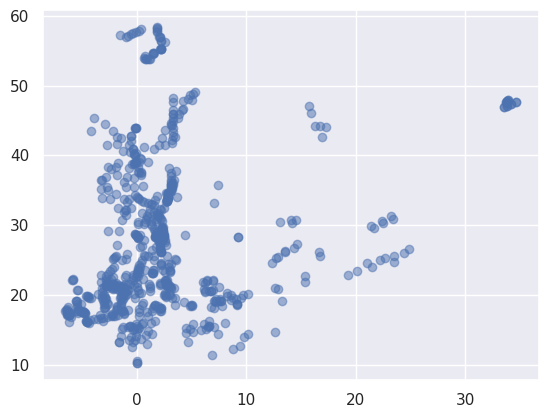

In [155]:
plt.scatter(angles, lookaheads, alpha=0.5)

In [156]:
hor_dist = np.sin(np.abs(angles)) * lookaheads

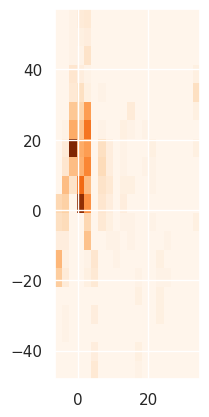

In [157]:
heatmap, xedges, yedges = np.histogram2d(angles, hor_dist, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


plt.clf()
plt.imshow(heatmap.T, cmap="Oranges", extent=extent, origin='lower')


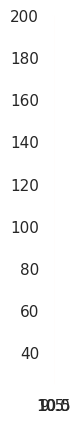

In [122]:
heatmap, xedges, yedges = np.histogram2d(, subset['Track_11'], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, cmap="Oranges", extent=extent, origin='lower')